### Reading dataset from *JSONL* file

In [ ]:
import json
import dill
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize

# Converting JSONL file into JSON
data = dict()
with open('../webis-touche2020/corpus.jsonl', 'r', encoding='utf-8') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        data[d['_id']] = d['title'] + ' ' + d['text']
        
docs = list(data.values())
keys = list(data.keys())

## Text Processing
Processing dataset text based on a bunch of rules:
###### Rule(1): 

In [2]:
def custom_tokenizer(doc):
    import re
    from nltk.tokenize import word_tokenize
    from emoji import emoji_list, demojize
    from nltk.corpus import stopwords
    stopwds = stopwords.words('english')

    
    def detect_url(doc):
        pattern = r'(?:https?\:)?(?:\/\/)?(?:[a-zA-Z0-9-]+\.)+[a-zA-Z0-9]+(?:\/[a-zA-z0-9]+)*'
        return re.match(pattern, doc)
    
    punctuation_pattern = r'[!"#$%&\'()*+,\-./:;<=>?@[\\\]^_`{|}~]'
    number_pattern = r'\b\d+\b'
    filtered_tokens = []
    tokens = word_tokenize(doc)

    for token in tokens:
        # URL handling
        if detect_url(token) is not None:
            filtered_tokens.append("Link")
        # Emoji Handling
        elif emoji_list(token):
            normalized_emoji = demojize(token).replace(':', ' ').strip()
            filtered_tokens.append(normalized_emoji)
        else: 
            # If token matches a punctuation mark; ignore it
            if not re.match(punctuation_pattern, token) and token not in stopwds:
                if re.match(number_pattern, token):
                    filtered_tokens.append('Number')
                else:
                    filtered_tokens.append(token) 
    return filtered_tokens 

#### Defining `TfidfVectorizer` model 


In [3]:
# Defining Vectorizer 
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,)
tfidf_matrix = vectorizer.fit_transform(docs)

### Handling User Query

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# tfidf_matrix = get_tfidf_matrix()
# vectorizer = get_vectorizer_instance()

def search(user_query, tfidf_matrix, docs, k=10): 
    user_query_vector = vectorizer.transform([user_query])
    similarities = cosine_similarity(user_query_vector, tfidf_matrix)
    top_indices = np.argpartition(similarities, -k, axis=None)[-k:]

    top_indices_sorted = top_indices[np.argsort(-similarities.ravel()[top_indices])]
    top_results = [(docs[i], keys[i], similarities[0, i]) for i in top_indices_sorted]
    return top_results


user_query = "Should teachers get tenure?"
k = 10
top_results = search(user_query, tfidf_matrix, docs, k)


with open('results.txt', 'w', encoding='utf-8') as rf:
    rf.writelines
    for doc, doc_id, similarity_score in top_results:
        rf.writelines(f"Doc Id: {doc_id}\n")
        # rf.writelines(f"Document: {doc}\n")
        # rf.writelines(f"Cosine Similarity Score: {similarity_score}\n")
        # rf.writelines('--------------------------------------\n')
rf.close()

In [7]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)   
kmeans.fit(tfidf_matrix)

def cluster_docs(kmeans) -> dict:
    clustered_documents = {i: [] for i in range(k)}
    for i, label in enumerate(kmeans.labels_):
        clustered_documents[label].append(i)
    return clustered_documents

clustered_indicies: dict = cluster_docs(kmeans)

In [ ]:
def search_by_cluster(
    user_query, vectorizer: TfidfVectorizer, kmeans: KMeans,
    tfidf_matrix, top_k=10
):
    user_query_vec = vectorizer.transform([user_query])
    query_cluster_lb = kmeans.predict(user_query_vec)[0]
    cluster_docs_indices = clustered_indicies[query_cluster_lb]

    retrieved_docs_vecs = tfidf_matrix[cluster_docs_indices]
    
    similarities = cosine_similarity(user_query_vec, retrieved_docs_vecs).flatten()
    top_indices = np.argsort(similarities)[-top_k:][::-1] 
    top_results = [(docs[i], keys[i], similarities[i], i) for i in top_indices]
    return top_results, query_cluster_lb

user_query="Is drinking milk healthy for humans?"

top_docs, label = search_by_cluster(
    user_query=user_query,
    kmeans=kmeans,
    tfidf_matrix=tfidf_matrix,
    vectorizer=vectorizer,
)

for doc, key, sim, i in top_docs:
    print(f"doc{i}: {doc}\n")

In [ ]:
# Topic detection 
def get_topic_tags(kmeans: KMeans, terms: list, lab_idx, top_n=3):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    return [terms[idx] for idx in order_centroids[lab_idx, :top_n]]

for topic in get_topic_tags(kmeans, vectorizer.get_feature_names_out(), label):
    print(topic)

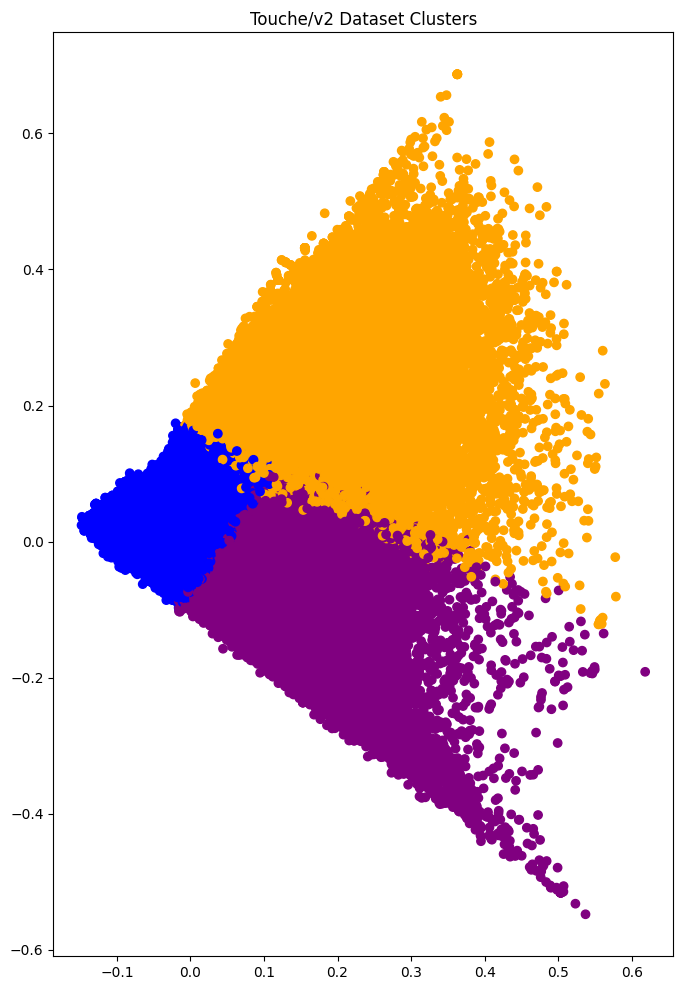

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans_indices = kmeans.predict(tfidf_matrix)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(tfidf_matrix)

colors = ['purple', 'orange', 'blue']
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(8, 12))

ax.set_title("Touche/v2 Dataset Clusters")
ax.scatter(x_axis, y_axis, c = [colors[d] for d in kmeans_indices])

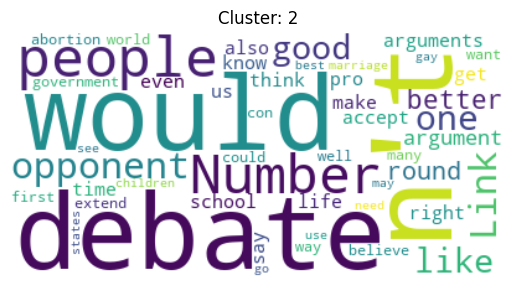

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def centroids(kmeans: KMeans):
    return kmeans.cluster_centers_.argsort()[:, ::-1]

def get_cluster_freqs(kmeans: KMeans, terms, cluster_index, k=3):
    if cluster_index > k:
        return None
    term_freqs = kmeans.cluster_centers_[cluster_index]
    sorted_items = centroids(kmeans)[cluster_index]
    freqs = {terms[i]: term_freqs[i] for i in sorted_items}
    return freqs

def display_wordcloud(frequencies):
    wordcloud = WordCloud(background_color='white', max_words=50)
    wordcloud.generate_from_frequencies(frequencies)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
freqs = get_cluster_freqs(kmeans, vectorizer.get_feature_names_out(), label, k)
if freqs: 
    plt.title(f"Cluster: {label}")
    display_wordcloud(freqs)

## Evaluation
#### Calculating *precision* score and *recall* score

In [15]:
import csv

def create_queries_inverted(queries_file):
    inverted_index = {}
    with open(queries_file, 'r') as f:
        next(f) # Skip first line of the file
        for line in f:
            query_id, text = line.strip().split('\t')
            inverted_index[query_id] = text
    return inverted_index

def create_qrels_inverted(qrels_file):
    inverted_index = {}
    with open(qrels_file, 'r') as f:
        next(f) # Skip first line of the file
        for line in f:
            query_id, document_id, score = line.strip().split('\t')
            score = int(score)
            query_id = query_id
            if query_id not in inverted_index:
                inverted_index[query_id] = []
            inverted_index[query_id].append((document_id, score))
                    
    # Sort index in descending order
    for query_id, doc_scores in inverted_index.items():
        inverted_index[query_id] = sorted(doc_scores, key=lambda x: x[1], reverse=True)
        
    return inverted_index

def get_retrieved_docs_for_query(
    query: str, tfidf_weight_matrix, k=10,
    embedding = False, clustering = False
) -> set:
    top_results = []
    if clustering:
        top_results = search_by_cluster(
            user_query=query,
            kmeans=kmeans,
            tfidf_matrix=tfidf_matrix,
            vectorizer=vectorizer,
        )
    else:
        top_results = search(query, tfidf_weight_matrix, docs)
    return set(result[1] for result in top_results)

def get_relevant_docs_for_query(query_id, k=10) -> set:
    relevant_docs = set()
    # for query_id, doc_scores in zip(qrels.keys(), qrels.values()):
    for doc_id, score in qrels[query_id]:
        relevant_docs.add(doc_id)
    return relevant_docs

def get_rel_ret_docs_for_query(
    query_id, query_txt: str, tfidf_matrix,
    k=10, embedding = False, clustering = False
):
    relevant_docs = get_relevant_docs_for_query(query_id)
    retrieved_docs = get_retrieved_docs_for_query(
        query_txt, tfidf_matrix, k, embedding, clustering
    )
    true_positives = retrieved_docs.intersection(relevant_docs)
    return relevant_docs, retrieved_docs, true_positives

def calculate_average_precision(relevant_docs, retrieved_docs, k=10): 
    precision_sum = 0
    true_positives_at_k = 0
    for i, retrieved_doc in enumerate(retrieved_docs, start=1):
        if retrieved_doc in relevant_docs:
            true_positives_at_k += 1
            precision_sum += true_positives_at_k / i
    return precision_sum / true_positives_at_k if true_positives_at_k > 0 else 0
        
def calculate_reciprocal_rank(relevant_docs, retrieved_docs, k=10):
    reciprocal_rank = 0
    for rank, retrieved_doc in enumerate(retrieved_docs, start=1):
            if retrieved_doc in relevant_docs:
                reciprocal_rank += 1 / rank
                break
    return reciprocal_rank

def calculate_pre_recall_ap_rr(relevant_docs, retrieved_docs, true_positives, k):
    precision = len(true_positives) / k if k > 0 else 0
    recall = len(true_positives)/ len(relevant_docs) if len(relevant_docs) > 0 else 0
    ap = calculate_average_precision(relevant_docs, retrieved_docs) 
    rr = calculate_reciprocal_rank(relevant_docs, retrieved_docs)
    return precision, recall, ap, rr

def evaluate(
    queries: dict, tfidf_matrix, file_path: str,
    embedding = False, clustering = False, k=10
):
    aps = 0
    rrs = 0
    with open(file_path, 'w', newline='', encoding='utf-8') as ef:  
        writer = csv.writer(ef, delimiter='\t')  
        writer.writerow(['Query-id', 'Precision', 'Recall', 'AP'])
        for query_id, query_txt in zip(queries.keys(), queries.values()):
            rel_docs, ret_docs, tps = get_rel_ret_docs_for_query(
                query_id, query_txt, tfidf_matrix, k, embedding, clustering
            )
            p, r, ap, rr = calculate_pre_recall_ap_rr(rel_docs, ret_docs, tps, k)
            writer.writerow([query_id, p, r, ap])
            aps += ap
            rrs += rr
    ef.close()
    mAP = aps / len(queries.keys())
    mRR = rrs / len(queries.keys())
    return  mAP, mRR

qrels_file = './qrels.tsv'
queries_file = './queries.tsv'

qrels = create_qrels_inverted(qrels_file)
queries = create_queries_inverted(queries_file)

eval_file_path = 'evaluation.tsv'
kmeans_eval_file_path = 'kmeans-evaluation.tsv'

mAP, mRR = evaluate(queries, tfidf_matrix, eval_file_path)

print(f"Mean Average Precision (mAP): {mAP}")
print(f'Mean Reciprocal Rank (mRR): {mRR}')    
  


Mean Average Precision (mAP): 0.37865389806716343
Mean Reciprocal Rank (mRR): 0.4519436345966959


### Suggest Questions

In [16]:
from textblob.en import Spelling
from textblob import TextBlob
import re

speller_file = 'speller_train.txt'
spelling = Spelling(speller_file)
user_query = "Are you a patient driver?"

def suggest_questions(user_query, k=2):
    qs = list(queries.values())
    user_query_vector = vectorizer.transform([user_query])
    queries_matrix = vectorizer.transform(qs)
    similarities = cosine_similarity(user_query_vector, queries_matrix)
    top_indices = np.argpartition(similarities, -k, axis=None)[-k:]
    top_results = [(qs[i], similarities[0, i]) for i in top_indices]
    return top_results

def train_speller(queries_file, spelling: Spelling):
    with open(queries_file, 'r') as f:
        next(f) # Skip first line of the file
        full_text = ''
        for line in f:
            query_id, text = line.strip().split('\t')
            full_text += str(text).lower()
    f.close()
    words = re.findall("[a-z]+", full_text)           
    one_string = " ".join(words)
    spelling.train(one_string, speller_file)

def spell_check(user_query, spelling: Spelling):
    return spelling.suggest(user_query)[0][0]

train_speller(queries_file, spelling)
corr_query = spell_check(user_query, spelling)

top_res_questions = suggest_questions(corr_query)
for doc, sim_score in top_res_questions:
    print(f"Suggested Question: {doc}\n")  

Suggested Question: Should churches remain tax-exempt?

Suggested Question: Should everyone get a universal basic income?



In [18]:
import dill 
path = "./datasets/touche/touche_"
with open(f'{path}matrix.pkl', 'wb') as mf:
    dill.dump(tfidf_matrix, mf)
mf.close()

with open(f'{path}model.pkl', 'wb') as bf:
    dill.dump(vectorizer, bf)
bf.close()

with open(f'{path}kmeans.pkl', 'wb') as kf:
    dill.dump(kmeans, kf)
kf.close()

with open(f'{path}terms.pkl', 'wb') as fnf:
    dill.dump(vectorizer.get_feature_names_out(), fnf)
fnf.close()

with open(f'{path}spelling.pkl', 'wb') as sf:
    dill.dump(spelling, sf)
sf.close()